# part 2

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from IPython.display import display, HTML
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

leasing = pd.read_csv("/Users/kaylienguyen/Downloads/Lease-revised.csv")
leasing.head

import folium
import ipywidgets as widgets
from IPython.display import display


# Coordinates of Manhattan zip codes
zip_coordinates = {
    '10001': [40.750633, -73.997177],  # Chelsea
    '10002': [40.715033, -73.984272],  # Lower East Side
    '10003': [40.731253, -73.989898],  # East Village
    '10004': [40.689247, -74.019740],  # Financial District
    '10005': [40.706046, -74.008899],  # Financial District
    '10006': [40.709329, -74.013138],  # Financial District
    '10007': [40.713103, -74.007894],  # Tribeca
    '10009': [40.726399, -73.978597],  # East Village
    '10010': [40.739127, -73.982732],  # Gramercy Park
    '10011': [40.742039, -74.000620],  # Chelsea
    '10012': [40.726104, -73.998334],  # SoHo
    '10013': [40.720804, -74.005124],  # SoHo/Tribeca
    '10014': [40.734012, -74.006622],  # West Village
    '10016': [40.745163, -73.978631],  # Murray Hill
    '10017': [40.752342, -73.972872],  # Midtown East
    '10018': [40.755363, -73.993580],  # Midtown
    '10019': [40.765823, -73.986542],  # Midtown West
    '10021': [40.769258, -73.958017],  # Upper East Side
    '10022': [40.758628, -73.967951],  # Midtown East
    '10023': [40.775921, -73.982605],  # Upper West Side
    '10024': [40.786015, -73.975011],  # Upper West Side
    '10025': [40.798408, -73.966243],  # Upper West Side
    '10026': [40.802450, -73.952370],  # Harlem
    '10027': [40.811550, -73.954987],  # Harlem
    '10028': [40.776441, -73.953622],  # Upper East Side
    '10029': [40.791763, -73.944628],  # East Harlem
    '10030': [40.818267, -73.942856],  # Harlem
    '10031': [40.825453, -73.949592],  # Hamilton Heights
    '10032': [40.838815, -73.942872],  # Washington Heights
    '10033': [40.850545, -73.933694],  # Washington Heights
    '10034': [40.867076, -73.924312],  # Inwood
    '10035': [40.795990, -73.933723],  # East Harlem
    '10036': [40.759425, -73.989252],  # Times Square/Hell's Kitchen
    '10037': [40.812957, -73.937376],  # Harlem
    '10038': [40.707872, -74.002881],  # South Street Seaport
    '10039': [40.826584, -73.936245],  # Harlem
    '10040': [40.858354, -73.930573],  # Washington Heights
}



class ManhattanLeaseVisualization:
    def __init__(self, lease_data, zip_coords):
        # Make a copy to avoid modifying the original data
        self.lease_data = lease_data.copy()
        self.zip_coords = zip_coords
        self.quarters = sorted(self.lease_data['quarter_year'].unique())
        self.process_data()
        
    def process_data(self):
        # Calculate min and max lease signings for scaling
        self.min_leases = self.lease_data['lease_signings'].min()
        self.max_leases = self.lease_data['lease_signings'].max()
        
        # Create a dictionary of data by quarter
        self.data_by_quarter = {}
        for quarter in self.quarters:
            quarter_data = self.lease_data[self.lease_data['quarter_year'] == quarter]
            self.data_by_quarter[quarter] = {
                row['zip']: row['lease_signings'] 
                for _, row in quarter_data.iterrows()
            }
    
    def create_map(self, quarter):
        # Create a base map centered on Manhattan
        manhattan_map = folium.Map(
            location=[40.776676, -73.971321],  # Midtown Manhattan coordinates
            zoom_start=12,
            tiles='CartoDB positron'
        )
        
        # Add circles for each zip code for the selected quarter
        quarter_data = self.data_by_quarter[quarter]
        
        for zip_code, leases in quarter_data.items():
            if zip_code in self.zip_coords:
                # Scale the radius based on the number of leases
                radius = self.scale_radius(leases)
                
                # Scale color based on the number of leases
                color = self.scale_color(leases)
                
                # Create a circle marker
                folium.CircleMarker(
                    location=self.zip_coords[zip_code],
                    radius=radius,
                    color=color,
                    fill=True,
                    fill_color=color,
                    fill_opacity=0.6,
                    popup=f"ZIP: {zip_code}<br>Leases: {leases}<br>Quarter: {quarter}",
                ).add_to(manhattan_map)
        
        # Display the map
        return manhattan_map
    
    def scale_radius(self, leases):
        """Scale the radius based on the number of leases (min 5, max 25)"""
        min_radius, max_radius = 5, 25
        if self.max_leases == self.min_leases:
            return (min_radius + max_radius) / 2
        return min_radius + (leases - self.min_leases) * (max_radius - min_radius) / (self.max_leases - self.min_leases)
    
    def scale_color(self, leases):
        """Scale the color based on the number of leases (green to red)"""
        if self.max_leases == self.min_leases:
            return '#FFA500'  # Orange if all values are the same
        
        # Create a colormap from green to red
        cmap = cm.get_cmap('RdYlGn_r')
        normalized = (leases - self.min_leases) / (self.max_leases - self.min_leases)
        rgba = cmap(normalized)
        
        # Convert RGBA to hex color
        hex_color = colors.rgb2hex(rgba)
        return hex_color

# Example data - replace this with your actual data
def create_example_data():
    """Create sample data for demonstration"""
    zips = list(zip_coordinates.keys())
    quarters = ['2023-Q1', '2023-Q2', '2023-Q3', '2023-Q4', '2024-Q1']
    
    data = []
    for quarter in quarters:
        for zip_code in zips:
            # Generate random lease signings between 10 and 200
            leases = np.random.randint(10, 200)
            data.append({
                'quarter_year': quarter,
                'zip': zip_code,
                'lease_signings': leases
            })
    
    return pd.DataFrame(data)

def create_visualization_for_jupyter(lease_data):
    """Create the visualization and display it in Jupyter"""
    # Create the visualization
    viz = ManhattanLeaseVisualization(lease_data, zip_coordinates)
    
    # Create an interactive slider to change the quarter
    quarter_slider = widgets.SelectionSlider(
        options=viz.quarters,
        value=viz.quarters[0],
        description='Quarter:',
        disabled=False
    )
    
    # Display the initial map
    map_viz = viz.create_map(quarter_slider.value)
    display(map_viz)
    
    # Define the interaction function
    def update_map(quarter):
        # Clear the previous map
        map_viz = viz.create_map(quarter)
        display(map_viz)
    
    # Link the slider to the update function
    widgets.interactive(update_map, quarter=quarter_slider)

# Example usage
example_data = create_example_data()
create_visualization_for_jupyter(example_data)


## New Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


leasing = pd.read_csv("/Users/kaylienguyen/Downloads/Lease-revised.csv")
leasing.head

<bound method NDFrame.head of         year  quarter  monthsigned   market            building_name  \
0       2018        1          1.0  Atlanta  10 Glenlake North Tower   
1       2018        1          1.0  Atlanta            100 City View   
2       2018        1          1.0  Atlanta            1000 Parkwood   
3       2018        1          1.0  Atlanta           1100 Circle 75   
4       2018        1          1.0  Atlanta             1200 Ashwood   
...      ...      ...          ...      ...                      ...   
194680  2024        4         12.0    Tampa              Building II   
194681  2024        4         12.0    Tampa             Midtown East   
194682  2024        4         12.0    Tampa               Park Tower   
194683  2024        4         12.0    Tampa          Rivergate Tower   
194684  2024        4         12.0    Tampa                 Spectrum   

                                              building_id  \
0       Atlanta_Central Perimeter_Atlanta_10

In [2]:
# create a quarter_year variable that combines the quarter and the year
leasing['quarter_year'] = pd.to_datetime(
    leasing['year'].astype(str) + '-' + leasing['quarter'].astype(str)
)

leasing.head(5)

# group by quarter and market
market_trends = leasing.groupby(['market', 'quarter_year']).size().reset_index(name='lease_signings')
market_trends.head(50)

#pivot table
market_pivot = market_trends.pivot(index='quarter_year', columns='market', values='lease_signings')
market_pivot

market,Atlanta,Austin,Baltimore,Boston,Charlotte,Chicago,Chicago Suburbs,Dallas/Ft Worth,Denver,Detroit,...,Raleigh/Durham,Salt Lake City,San Diego,San Francisco,Seattle,South Bay/San Jose,South Florida,Southern Maryland,Tampa,Washington D.C.
quarter_year,,,,,,,,,,,,,,,,,,,,,
2018-01-01,290,198,129,355,133,220,227,562,357,176,...,67,72,265,168,265,190,401,108,179,180
2018-02-01,333,207,169,424,134,259,274,755,430,173,...,79,68,302,225,282,217,457,129,181,221
2018-03-01,321,204,137,377,164,216,200,684,337,164,...,84,50,264,197,237,214,456,121,169,184
2018-04-01,316,178,154,357,109,195,190,657,349,151,...,90,56,214,168,268,161,359,111,202,160
2019-01-01,335,217,162,345,128,250,242,651,363,165,...,88,66,222,162,219,128,395,116,171,152
2019-02-01,294,240,139,309,134,235,225,784,359,115,...,88,66,232,194,210,160,430,106,150,137
2019-03-01,345,223,140,325,121,229,219,723,382,105,...,93,58,269,213,247,143,426,94,163,174
2019-04-01,349,204,162,336,149,257,221,712,369,128,...,96,63,230,142,195,171,423,96,177,168
2020-01-01,303,201,169,323,119,253,222,584,290,166,...,88,57,256,151,185,145,404,141,161,172


<Figure size 1200x1200 with 0 Axes>

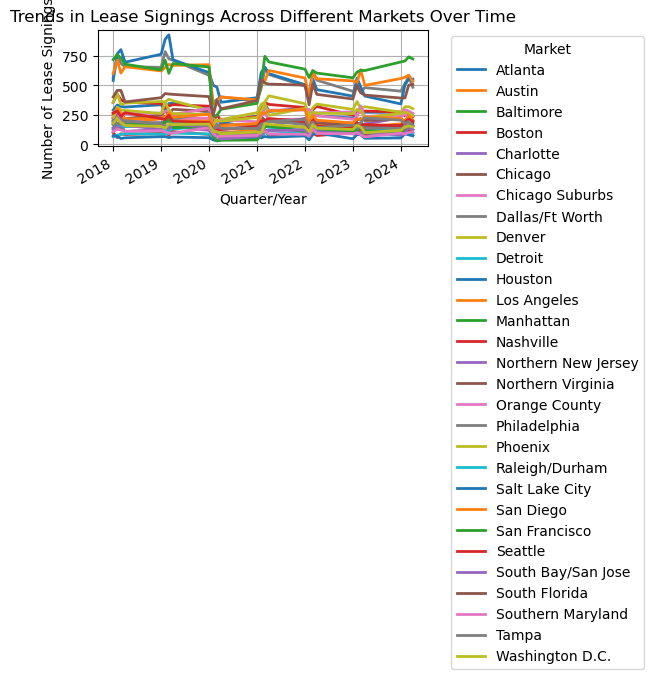

In [3]:
plt.figure(figsize=(12, 12))
market_pivot.plot(lw=2)
plt.title('Trends in Lease Signings Across Different Markets Over Time')
plt.xlabel('Quarter/Year')
plt.ylabel('Number of Lease Signings')
plt.legend(title='Market', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
# Filter for finance and tech industries
target_industries = ["Financial Services and Insurance", "Technology, Advertising, Media, and Information", "Legal Services"]
filtered_df = leasing[leasing['internal_industry'].isin(target_industries)]

# Group by market and industry, then count rows (this is essentially counting leases per market/industry combination)
industry_market_counts = filtered_df.groupby(['market', 'internal_industry']).size().reset_index(name='count')

# Print the results to see the counts
print(industry_market_counts)



             market                                internal_industry  count
0           Atlanta                 Financial Services and Insurance    199
1           Atlanta                                   Legal Services     70
2           Atlanta  Technology, Advertising, Media, and Information    147
3            Austin                 Financial Services and Insurance     66
4            Austin                                   Legal Services     38
..              ...                                              ...    ...
82            Tampa                                   Legal Services     65
83            Tampa  Technology, Advertising, Media, and Information     52
84  Washington D.C.                 Financial Services and Insurance     79
85  Washington D.C.                                   Legal Services    204
86  Washington D.C.  Technology, Advertising, Media, and Information    129

[87 rows x 3 columns]


In [5]:
# Group by market and internal_industry, then count the leases
industry_market_counts = filtered_df.groupby(['market', 'internal_industry']).size().reset_index(name='count')

# Sort by industry and count of leases, descending order
industry_market_counts_sorted = industry_market_counts.sort_values(by=['internal_industry', 'count'], ascending=[True, False])

# Get the top 5 markets for each industry
top_5_markets_by_industry = industry_market_counts_sorted.groupby('internal_industry').head(5)

# Print the top 5 markets for each industry
print(top_5_markets_by_industry)


                market                                internal_industry  count
36           Manhattan                 Financial Services and Insurance   1400
0              Atlanta                 Financial Services and Insurance    199
21     Dallas/Ft Worth                 Financial Services and Insurance    190
15             Chicago                 Financial Services and Insurance    188
75       South Florida                 Financial Services and Insurance    184
37           Manhattan                                   Legal Services    393
85     Washington D.C.                                   Legal Services    204
16             Chicago                                   Legal Services    148
34         Los Angeles                                   Legal Services    145
31             Houston                                   Legal Services    113
38           Manhattan  Technology, Advertising, Media, and Information    868
47   Northern Virginia  Technology, Advertising, Med

In [6]:
fs_and_insurance_df = leasing[leasing['internal_industry'] == 'Financial Services and Insurance']
legal_services_df = leasing[leasing['internal_industry'] == 'Legal Services']
technology_df = leasing[leasing['internal_industry'] == 'Technology, Advertising, Media, and Information']


In [7]:
leasing['monthsigned'] = pd.to_numeric(leasing['monthsigned'], errors='coerce').fillna(0).astype(int)
leasing = leasing[leasing['monthsigned'] > 0]
leasing['monthsigned'] = leasing['monthsigned'].astype(str).str.zfill(2)

leasing['monthsigned']

/var/folders/3m/hxyrmk3x0fndxrfylccz8ldh0000gn/T/ipykernel_62709/2918501750.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leasing['monthsigned'] = leasing['monthsigned'].astype(str).str.zfill(2)


0         01
1         01
2         01
3         01
4         01
          ..
194680    12
194681    12
194682    12
194683    12
194684    12
Name: monthsigned, Length: 193822, dtype: object

In [8]:
# Ensure the 'year' and 'month' are in a single 'date' column for easier handling

leasing['monthsigned'] = pd.to_numeric(leasing['monthsigned'], errors='coerce').fillna(0).astype(int)
leasing['monthsigned'] = leasing['monthsigned'].astype(str).str.zfill(2)
leasing['date'] = pd.to_datetime(leasing['year'].astype(str) + '-' + leasing['monthsigned'].astype(str), format='%Y-%m')
#print(leasing['date'])

# Group by market and date, and count the number of leases per month
market_monthly_leases = leasing.groupby(['market', 'date']).size().reset_index(name='lease_count')

# Calculate the month-over-month percent growth for each market
market_monthly_leases['pct_growth'] = market_monthly_leases.groupby('market')['lease_count'].pct_change() * 100

# Filter out rows with NaN values (which result from the first row of each market group)
market_monthly_leases = market_monthly_leases.dropna(subset=['pct_growth'])

# Calculate the average growth for each market
avg_growth_by_market = market_monthly_leases.groupby('market')['pct_growth'].mean().reset_index()

# Sort by average percent growth to get the top 5 fastest-growing markets
top_5_fastest_growing_markets = avg_growth_by_market.sort_values(by='pct_growth', ascending=False).head(5)

# Display the top 5 fastest-growing markets
print(top_5_fastest_growing_markets)


/var/folders/3m/hxyrmk3x0fndxrfylccz8ldh0000gn/T/ipykernel_62709/2453754344.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leasing['monthsigned'] = pd.to_numeric(leasing['monthsigned'], errors='coerce').fillna(0).astype(int)
/var/folders/3m/hxyrmk3x0fndxrfylccz8ldh0000gn/T/ipykernel_62709/2453754344.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leasing['monthsigned'] = leasing['monthsigned'].astype(str).str.zfill(2)


             market  pct_growth
8            Denver  134.564554
0           Atlanta  126.611317
10          Houston   78.338344
7   Dallas/Ft Worth   72.064681
28  Washington D.C.   70.080152


/var/folders/3m/hxyrmk3x0fndxrfylccz8ldh0000gn/T/ipykernel_62709/2453754344.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  leasing['date'] = pd.to_datetime(leasing['year'].astype(str) + '-' + leasing['monthsigned'].astype(str), format='%Y-%m')


##  looking only at manhattan market

In [9]:
manhattan_df = leasing[leasing['market'] == 'Manhattan']
manhattan_df.head(5)

,year,quarter,monthsigned,market,building_name,building_id,address,region,city,state,...,direct_availability_proportion,direct_internal_class_rent,direct_overall_rent,sublet_available_space,sublet_availability_proportion,sublet_internal_class_rent,sublet_overall_rent,leasing,quarter_year,date
1412,2018,1,01,Manhattan,1 E 33rd St,Manhattan_Park Avenue South_New York_1 E 33rd ...,1-13 E 33rd St,Northeast,New York,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3789831.0,2018-01-01,2018-01-01
1413,2018,1,01,Manhattan,1 Park Ave,Manhattan_Park Avenue South_New York_1 Park Av...,One Park Ave,Northeast,New York,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3789831.0,2018-01-01,2018-01-01
1414,2018,1,01,Manhattan,1 Trinity Centre,Manhattan_WTC/Brookfield Place_New York_1 Trin...,111 Broadway,Northeast,New York,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3789831.0,2018-01-01,2018-01-01
1415,2018,1,01,Manhattan,10 Rockefeller Plz,Manhattan_Plaza South_New York_10 Rockefeller ...,10 Rockefeller Plaza,Northeast,New York,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5131601.0,2018-01-01,2018-01-01
1416,2018,1,01,Manhattan,100104 Fifth Avenue,Manhattan_Flatiron_New York_100104 Fifth Avenu...,100-104 5th Ave,Northeast,New York,NY,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3789831.0,2018-01-01,2018-01-01


In [10]:
fs_and_insurance_df = manhattan_df[manhattan_df['internal_industry'] == 'Financial Services and Insurance']
legal_services_df = manhattan_df[manhattan_df['internal_industry'] == 'Legal Services']
technology_df = manhattan_df[manhattan_df['internal_industry'] == 'Technology, Advertising, Media, and Information']

In [14]:
# Calculate the proportion of each transaction_type within each industry
fs_and_insurance_proportion = fs_and_insurance_df.groupby('transaction_type').size() / len(fs_and_insurance_df)
legal_services_proportion = legal_services_df.groupby('transaction_type').size() / len(legal_services_df)
technology_proportion = technology_df.groupby('transaction_type').size() / len(technology_df)

# Convert the proportions to DataFrames and reset index
fs_and_insurance_proportion = fs_and_insurance_proportion.reset_index(name='proportion')
legal_services_proportion = legal_services_proportion.reset_index(name='proportion')
technology_proportion = technology_proportion.reset_index(name='proportion')

# Add a new column to each DataFrame to label the industry
fs_and_insurance_proportion['industry'] = 'Financial Services and Insurance'
legal_services_proportion['industry'] = 'Legal Services'
technology_proportion['industry'] = 'Technology, Advertising, Media, and Information'

# Display the proportions for each industry
print("Financial Services and Insurance Proportions:")
print(fs_and_insurance_proportion)

print("\nLegal Services Proportions:")
print(legal_services_proportion)

print("\nTechnology, Advertising, Media, and Information Proportions:")
print(technology_proportion)


Financial Services and Insurance Proportions:
        transaction_type  proportion                          industry
0              Expansion    0.121543  Financial Services and Insurance
1              Extension    0.002911  Financial Services and Insurance
2                    New    0.229985  Financial Services and Insurance
3             Relocation    0.386463  Financial Services and Insurance
4                Renewal    0.176128  Financial Services and Insurance
5  Renewal and Expansion    0.056041  Financial Services and Insurance
6            Restructure    0.013828  Financial Services and Insurance
7       Sale - Leaseback    0.001456  Financial Services and Insurance
8                    TBD    0.003639  Financial Services and Insurance

Legal Services Proportions:
        transaction_type  proportion        industry
0              Expansion    0.118421  Legal Services
1              Extension    0.010526  Legal Services
2                    New    0.163158  Legal Services
3  

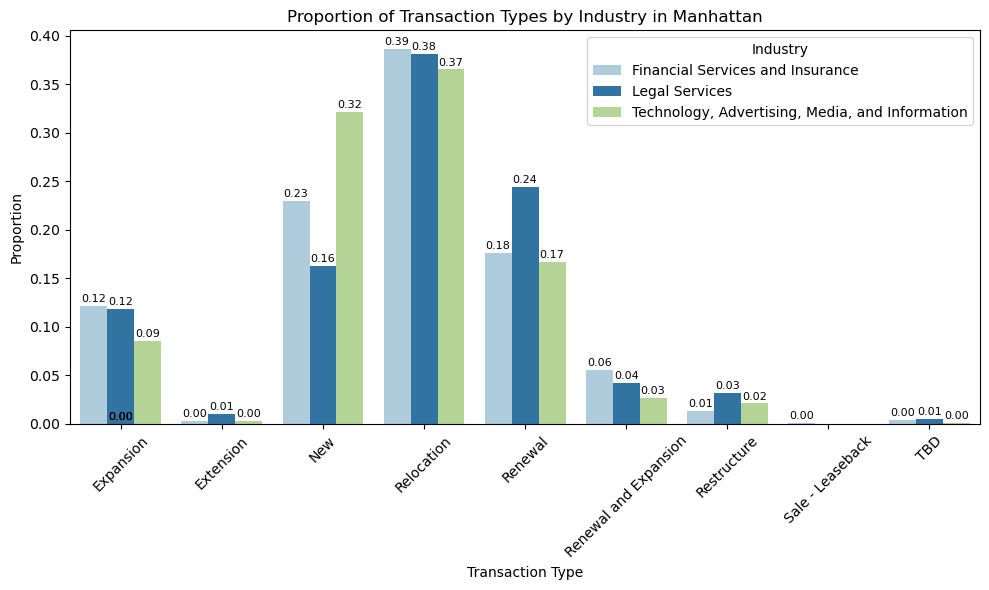

In [15]:

# Combine the proportions into a single DataFrame
fs_and_insurance_proportion['industry'] = 'Financial Services and Insurance'
legal_services_proportion['industry'] = 'Legal Services'
technology_proportion['industry'] = 'Technology, Advertising, Media, and Information'

# Concatenate the three DataFrames
combined_proportions = pd.concat([fs_and_insurance_proportion, legal_services_proportion, technology_proportion])

# Plot the data using seaborn with 'Paired' color palette
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='transaction_type', y='proportion', hue='industry', data=combined_proportions, palette='Paired')

# Customize the plot
plt.title('Proportion of Transaction Types by Industry in Manhattan')
plt.xlabel('Transaction Type')
plt.ylabel('Proportion')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend(title='Industry')

# Add smaller numbers above each bar with Paired color palette
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',  # Format the proportion to 2 decimal places
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label above the bar
                ha='center', va='center',  # Align text at the center
                fontsize=8, color='black',  # Smaller text and black color
                xytext=(0, 5),  # Offset the label a bit higher
                textcoords='offset points')

# Display the plot
plt.tight_layout()
plt.show()
